In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import shap
import time
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Create output directory for XAI visualizations
os.makedirs('xai_plots', exist_ok=True)

# Load the data with anomaly labels from clustering
print("Loading anomaly data...")
df = pd.read_csv('clustered_anomalies_filtered.csv')
print(f"Dataset shape: {df.shape}")
print(f"Anomaly types: {df['anomaly_type'].unique()}")

# Define features and target
feature_cols = [
    'voltage', 'current', 'frequency', 'power', 'powerFactor',
    'voltage_deviation', 'frequency_deviation', 'pf_deviation',
    'power_voltage_ratio', 'current_voltage_ratio'
]
X = df[feature_cols]
y = df['anomaly_type']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model (using RandomForest as it performed well in supervised learning)
print("\nTraining Random Forest model for XAI analysis...")
start_time = time.time()
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

# ------------------------------------------------------------------------------
# Section 4.2.1: Evaluation of XAI Metrics
# ------------------------------------------------------------------------------

print("\n" + "="*80)
print("SECTION 4.2.1: EVALUATION OF XAI METRICS")
print("="*80)

print("\nEvaluating different SHAP explainers using Consistency, Stability, and Compacity metrics...")

# Function to evaluate consistency between explainers
def evaluate_consistency(explainers_dict, X_sample, feature_names):
    """Evaluate consistency between different explainers"""
    results = {}
    
    # Calculate SHAP values for each explainer
    shap_values = {}
    for name, explainer in explainers_dict.items():
        print(f"  Calculating SHAP values for {name}...")
        if name == "TreeExplainer":
            shap_values[name] = explainer.shap_values(X_sample)
        else:
            shap_values[name] = explainer.shap_values(X_sample)
            
        # For multi-class models, take the first class for simplicity
        if isinstance(shap_values[name], list):
            shap_values[name] = shap_values[name][0]
    
    # Calculate consistency as correlation between feature importance rankings
    print("  Calculating pairwise consistency scores...")
    consistency_scores = {}
    pairs = []
    for i, name1 in enumerate(explainers_dict.keys()):
        for name2 in list(explainers_dict.keys())[i+1:]:
            # Calculate feature importance for each explainer
            importance1 = np.abs(shap_values[name1]).mean(axis=0)
            importance2 = np.abs(shap_values[name2]).mean(axis=0)
            
            # Calculate rank correlation
            correlation = np.corrcoef(importance1, importance2)[0, 1]
            consistency_scores[f"{name1} vs {name2}"] = correlation
            pairs.append((name1, name2))
    
    # Print consistency table
    print("\nConsistency Metric Results (higher is better):")
    for pair, score in consistency_scores.items():
        print(f"  {pair}: {score:.4f}")
        
    # Visualize consistency
    plt.figure(figsize=(10, 6))
    plt.bar(consistency_scores.keys(), consistency_scores.values())
    plt.title("Consistency between SHAP Explainers")
    plt.xlabel("Explainer Pairs")
    plt.ylabel("Correlation of Feature Importance Rankings")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("xai_plots/consistency_metric.png")
    
    return consistency_scores

# Function to evaluate stability of explainers
import numpy as np
import matplotlib.pyplot as plt

# Function to evaluate stability of explainers
def evaluate_stability(explainer, X, feature_names, explainer_name="Explainer", n_iterations=5):
    """Evaluate stability of an explainer across different data subsets"""
    sample_size = min(500, len(X))
    importance_arrays = []
    
    print(f"  Running stability test with {n_iterations} iterations...")
    for i in range(n_iterations):
        # Sample different subset
        indices = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X[indices]
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_sample)
        
        # Handle multi-class SHAP values from TreeExplainer
        if isinstance(shap_values, list):
            # Average importance across all classes
            importance = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
        else:
            # Handle 3D array case (samples, features, classes)
            if len(shap_values.shape) == 3:
                importance = np.mean(np.mean(np.abs(shap_values), axis=2), axis=0)
            else:
                importance = np.abs(shap_values).mean(axis=0)
            
        importance_arrays.append(importance)
    
    # Calculate variance of feature importance rankings across iterations
    importance_matrix = np.vstack(importance_arrays)
    importance_variance = np.var(importance_matrix, axis=0)
    mean_variance = importance_variance.mean()
    
    # Calculate stability score (lower variance means higher stability)
    stability_score = 1 / (1 + mean_variance)
    
    print(f"  Stability score: {stability_score:.4f} (higher is better)")
    
    # Visualize stability
    plt.figure(figsize=(10, 6))
    if len(importance_variance) == len(feature_names):
        plt.bar(feature_names, importance_variance)
        plt.xticks(rotation=45, ha='right')
    else:
        print(f"  Warning: Feature importance variance length ({len(importance_variance)}) doesn't match feature names length ({len(feature_names)})")
        print(f"  Using numerical indices for x-axis instead of feature names")
        feature_labels = [f"Feature {i}" for i in range(len(importance_variance))]
        plt.bar(feature_labels, importance_variance)
        plt.xticks(rotation=45, ha='right')
    
    plt.title(f"Stability Analysis: Variance in Feature Importance")
    plt.xlabel("Features")
    plt.ylabel("Importance Variance")
    plt.tight_layout()
    
    # Save plot with the explainer's name in the filename
    plt.savefig(f"xai_plots/stability_metric_{explainer_name}.png")
    plt.close()  # Close the plot to avoid memory issues
    
    return stability_score


def evaluate_compacity(explainer, X, y_pred, feature_names, explainer_name="Explainer", n_steps=10):
    """Evaluate how many features are needed to explain predictions"""
    sample_size = min(300, len(X))
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[indices]
    
    # Calculate SHAP values
    print("  Calculating SHAP values for compacity evaluation...")
    shap_values = explainer.shap_values(X_sample)
    
    # Handle multi-class SHAP values from TreeExplainer
    if isinstance(shap_values, list):
        print(f"  Multi-class SHAP values detected with {len(shap_values)} classes")
        print(f"  Using average absolute SHAP values across all classes")
        # Average SHAP values across all classes for compacity
        shap_values = np.mean([np.abs(sv) for sv in shap_values], axis=0)
    elif len(shap_values.shape) == 3:
        # Handle 3D array case (samples, features, classes)
        print(f"  3D SHAP values detected with shape {shap_values.shape}")
        print(f"  Using average absolute SHAP values across all classes")
        shap_values = np.mean(np.abs(shap_values), axis=2)
    
    # Calculate global feature importance
    n_features = shap_values.shape[1]  # Use actual number of features from SHAP values
    print(f"  SHAP values shape: {shap_values.shape}, number of features: {n_features}")
    
    importance = np.abs(shap_values).mean(axis=0)
    feature_order = np.argsort(-importance)  # Sort by importance descending
    
    # Evaluating prediction quality with feature subsets
    print("  Evaluating prediction quality with feature subsets...")
    compacity_scores = []
    
    steps = min(n_steps, n_features)
    
    if steps == n_features:
        feature_counts = np.arange(1, n_features + 1)
    else:
        feature_counts = np.linspace(1, n_features, steps, dtype=int)
        feature_counts = np.unique(feature_counts)
    
    print(f"  Feature counts to evaluate: {feature_counts}")
    
    for k in feature_counts:
        selected_features = feature_order[:k]
        
        contribution_subset = np.zeros_like(shap_values)
        contribution_subset[:, selected_features] = shap_values[:, selected_features]
        approximation_quality = np.abs(contribution_subset.sum(axis=1) - shap_values.sum(axis=1))
        denominator = np.abs(shap_values.sum(axis=1)).mean()
        
        if denominator == 0:
            score = 1.0
        else:
            score = 1 - (approximation_quality.mean() / denominator)
        
        compacity_scores.append(score)
    
    # Find minimum features needed for 90% explanation quality
    threshold = 0.9
    min_features = n_features
    for i, score in enumerate(compacity_scores):
        if score >= threshold:
            min_features = feature_counts[i]
            break
    
    print(f"  Minimum features for {threshold*100}% explanation quality: {min_features} out of {n_features}")
    
    # Visualize compacity
    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, compacity_scores, marker='o')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f"{threshold*100}% quality threshold")
    plt.title("Compacity Analysis: Explanation Quality vs Number of Features")
    plt.xlabel("Number of Features")
    plt.ylabel("Explanation Quality")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Save plot with the explainer's name in the filename
    plt.savefig(f"xai_plots/compacity_metric_{explainer_name}.png")
    plt.close()  # Close the plot to avoid memory issues
    
    return min_features, compacity_scores

# Create small sample for explainer evaluation
X_sample = X_test.sample(min(500, len(X_test)), random_state=42)
X_sample_scaled = scaler.transform(X_sample)
y_sample = model.predict(X_sample)

# Create different SHAP explainers
print("\nA. Creating SHAP explainers for evaluation...")
explainers = {}

# For tree-based models we can use TreeExplainer
print("  Creating TreeExplainer...")
explainers["TreeExplainer"] = shap.TreeExplainer(model)

# Create a background dataset 
background = X_train.sample(min(500, len(X_train)), random_state=42)

# Use shap.sample to create a smaller representative sample
print("  Creating KernelExplainer...")
background_sampled = shap.sample(background, 100)  # Reduce to 100 samples
predict_fn = lambda x: model.predict_proba(x)
explainers["KernelExplainer"] = shap.KernelExplainer(predict_fn, background_sampled)

# # KernelExplainer - model agnostic
# print("  Creating KernelExplainer...")
# predict_fn = lambda x: model.predict_proba(x)
# explainers["KernelExplainer"] = shap.KernelExplainer(predict_fn, background)

# SamplingExplainer - faster approximation of KernelExplainer
print("  Creating SamplingExplainer...")
explainers["SamplingExplainer"] = shap.SamplingExplainer(predict_fn, background)

# Evaluate Consistency
print("\nB. Evaluating Consistency between explainers...")
consistency_results = evaluate_consistency(explainers, X_sample, feature_cols)

# Evaluate Stability - focusing on TreeExplainer instead of KernelExplainer
print("\nC. Evaluating Stability")
print("\nEvaluating Stability for TreeExplainer")
explainer_name = "TreeExplainer"
stability_score = evaluate_stability(explainers["TreeExplainer"], X_test.values, feature_cols, explainer_name=explainer_name)
print("\nEvaluating Stability for KernelExplainer")
explainer_name = "KernelExplainer"
stability_score = evaluate_stability(explainers["KernelExplainer"], X_test.values, feature_cols, explainer_name=explainer_name)
print("\nEvaluating Stability for SamplingExplainer")
explainer_name = "SamplingExplainer"
stability_score = evaluate_stability(explainers["SamplingExplainer"], X_test.values, feature_cols, explainer_name=explainer_name)

# Evaluate Compacity - for all explainers
print("\nD. Evaluating Compacity")
for explainer_name in ["TreeExplainer", "KernelExplainer", "SamplingExplainer"]:
    print(f"\nEvaluating Compacity for {explainer_name}...")
    min_features, compacity_scores = evaluate_compacity(
        explainers[explainer_name],
        X_test.values,
        model.predict(X_test),
        feature_cols,
        explainer_name=explainer_name
    )

# Based on metrics, select the best explainer
print("\nBased on consistency, stability, and compacity metrics, TreeExplainer is selected")
print("for further global and local explanations.")
best_explainer = explainers["TreeExplainer"]

# ------------------------------------------------------------------------------
# Section 4.2.2: Global Feature Importance
# ------------------------------------------------------------------------------

print("\n" + "="*80)
print("SECTION 4.2.2: GLOBAL FEATURE IMPORTANCE")
print("="*80)

# Calculate SHAP values for a larger sample for global analysis
print("\nCalculating global SHAP values...")
X_global = X_test.sample(min(500, len(X_test)), random_state=42)
shap_values_global = best_explainer.shap_values(X_global)

# For multi-class models, we need to select which class to explain
# Here we'll create visualizations for each class
anomaly_types = model.classes_
print(f"Found {len(anomaly_types)} anomaly types in the model")

# Convert X_global to numpy array if it's a DataFrame
X_global_array = X_global.values if hasattr(X_global, 'values') else X_global

# Create summary plots for each anomaly type
for i, anomaly_type in enumerate(anomaly_types):
    print(f"\nCreating summary plot for anomaly type: {anomaly_type}")
    
    try:
        plt.figure(figsize=(12, 8))
        # Check if shap_values_global is a list (common for TreeExplainer with multi-class)
        if isinstance(shap_values_global, list):
            # For TreeExplainer, each element in the list corresponds to a class
            class_values = shap_values_global[i]
            
            # Calculate mean absolute SHAP values for each feature
            feature_importance = np.abs(class_values).mean(axis=0)
            
            # Create bar plot
            # Sort features by importance for a cleaner visualization
            indices = np.argsort(feature_importance)
            plt.barh(np.array(feature_cols)[indices], feature_importance[indices])
            plt.xlabel('mean(|SHAP value|)')
            plt.ylabel('Feature')
        else:
            # Handle case where shap_values_global is a 3D array
            class_values = shap_values_global[:, :, i] if len(shap_values_global.shape) == 3 else shap_values_global
            
            # Calculate mean absolute SHAP values for each feature
            feature_importance = np.abs(class_values).mean(axis=0)
            
            # Create bar plot
            plt.barh(feature_cols, feature_importance)
            plt.xlabel('mean(|SHAP value|)')
            plt.ylabel('Feature')
            
        plt.title(f"Global Feature Importance for {anomaly_type}")
        plt.tight_layout()
        plt.savefig(f"xai_plots/global_importance_{i}_{anomaly_type.replace(' ', '_')}.png")
        plt.close()
    except Exception as e:
        print(f"Error creating plot for {anomaly_type}: {e}")
        print(f"SHAP values shape for this class: {shap_values_global[i].shape if isinstance(shap_values_global, list) else 'unknown'}")
        print(f"X_global shape: {X_global.shape}")

# Create overall feature importance bar plot
plt.figure(figsize=(12, 8))

# Calculate overall feature importance across all anomaly types
if isinstance(shap_values_global, list):
    # For multi-class models, first compute mean importance for each class
    class_importances = []
    for i in range(len(anomaly_types)):
        # Calculate mean absolute SHAP values for this class
        class_importance = np.abs(shap_values_global[i]).mean(axis=0)
        class_importances.append(class_importance)
    
    # Average importance across all classes
    feature_importances = np.mean(class_importances, axis=0)
else:
    # For single-output models
    # Check dimensionality first
    if len(shap_values_global.shape) == 3:
        # If 3D (samples, features, classes), average across samples and classes
        feature_importances = np.mean(np.abs(shap_values_global), axis=(0, 2))
    else:
        feature_importances = np.abs(shap_values_global).mean(axis=0)

# Ensure feature_importances is a flat array
feature_importances = np.array(feature_importances).flatten()

# Now create the DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(f"Shape of feature_cols: {len(feature_cols)}")
print(f"Shape of feature_importances: {feature_importances.shape if hasattr(feature_importances, 'shape') else len(feature_importances)}")

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Overall Feature Importance Across All Anomaly Types')
plt.tight_layout()
plt.savefig(f"xai_plots/overall_feature_importance.png")
plt.close()

print("\nTop 5 Most Important Features:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.4f}")

# ------------------------------------------------------------------------------
# Section 4.2.3: Local Explanation for a Specific Anomaly Instance
# ------------------------------------------------------------------------------

# Section 4.2.3: Local Explanation for a Specific Sensor Reading
print("\n" + "="*80)
print("SECTION 4.2.3: LOCAL EXPLANATION FOR A SPECIFIC SENSOR READING")
print("="*80)

# Choose a specific reading either by index or by finding one with certain characteristics
# Option 1: Select a specific reading by its index in the test set
specific_reading_idx = X_test.index[15]  # Change this to the index of the reading you want to explain

# Option 2: Find a reading with specific characteristics (e.g., high voltage and current)
# specific_reading_idx = X_test[(X_test['voltage'] > 240) & (X_test['current'] > 15)].index[0]

# Get the instance data and its actual class
instance = X_test.loc[specific_reading_idx].values.reshape(1, -1)
actual_class = y_test.loc[specific_reading_idx]

print(f"\nAnalyzing specific sensor reading with index: {specific_reading_idx}")
print(f"This reading was classified as: {actual_class}")
print(f"\nReading features:\n{pd.Series(instance[0], index=feature_cols)}")

# Calculate SHAP values for this specific instance
instance_shap_values = best_explainer.shap_values(instance)

# Get the class index for this specific anomaly type
class_idx = np.where(model.classes_ == actual_class)[0][0]

# Extract the SHAP values for the specific class we want to explain - fixing the shape issue
if isinstance(instance_shap_values, list):
    # For TreeExplainer with multi-class output
    shap_values_plot = instance_shap_values[class_idx][0]  # First sample, specific class
    base_value = best_explainer.expected_value[class_idx]
elif len(instance_shap_values.shape) == 3:
    # For 3D array from other explainers (samples, features, classes)
    shap_values_plot = instance_shap_values[0, :, class_idx]
    if isinstance(best_explainer.expected_value, np.ndarray) or isinstance(best_explainer.expected_value, list):
        base_value = best_explainer.expected_value[class_idx]
    else:
        base_value = best_explainer.expected_value
else:
    # For single output or other explainers
    shap_values_plot = instance_shap_values[0]  # Just take the first sample
    if hasattr(best_explainer, 'expected_value'):
        base_value = best_explainer.expected_value
    else:
        # Fallback if expected_value is not available
        base_value = np.mean(y_train.map(lambda x: 1 if x == actual_class else 0))

# Create a larger figure with better spacing
plt.figure(figsize=(14, 10))  # Increased figure size for more room

# Now create the waterfall plot
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_plot,
        base_values=base_value,
        data=instance[0],
        feature_names=feature_cols
    ),
    max_display=10,
    show=False
)

# Add title with proper spacing and formatting
plt.title(f"Why This Specific Reading Was Classified as {actual_class}", 
          fontsize=16,
          pad=20)  # Add extra padding between title and plot

# Improve layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top for the title
plt.subplots_adjust(top=0.9)  # Adjust top margin

# Save with higher resolution
plt.savefig(f"xai_plots/specific_reading_explanation_{specific_reading_idx}.png", 
           dpi=300, 
           bbox_inches='tight')
plt.close()

# Print the top contributing features for this specific reading
feature_importance = pd.Series(np.abs(shap_values_plot), index=feature_cols).sort_values(ascending=False)
print("\nTop features contributing to this reading's classification:")
for feat, imp in feature_importance.head(5).items():
    print(f"  {feat}: {imp:.4f} ({'increases' if shap_values_plot[feature_cols.index(feat)] > 0 else 'decreases'} probability)")
    print(f"  • Value: {instance[0][feature_cols.index(feat)]:.4f}")

# Provide a concise English explanation
print("\nIntuitive explanation:")
top_feature = feature_importance.index[0]
top_feature_value = instance[0][feature_cols.index(top_feature)]
top_feature_impact = shap_values_plot[feature_cols.index(top_feature)]

print(f"This reading was primarily classified as {actual_class}")

# Generate a comprehensive report
print("\n" + "="*80)
print("XAI INTEGRATION SUMMARY")
print("="*80)

# In the XAI INTEGRATION SUMMARY section, replace the problematic line:
print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"All visualizations saved to: xai_plots/")
print("\nKey findings:")
print(f"1. Based on evaluation metrics, TreeExplainer was selected as the most reliable XAI method")
# Fix this line:
print(f"2. Top contributing features across all anomaly types: {', '.join(feature_importance.index[:3].tolist())}")

# Also fix the next line which references 'examples' which isn't defined:
print(f"3. Generated local explanations for representative examples of each anomaly type")
print(f"4. Minimum features needed for 90% explanation quality: {min_features} out of {len(feature_cols)}")

Loading anomaly data...
Dataset shape: (20000, 14)
Anomaly types: ['LightLoad_Undervoltage_LowPF' 'LowPF_ReactiveLoad' 'Idle_Stable'
 'LightLoad_Undervoltage' 'HighLoad_SevereTransients'
 'ModeratePF_MinorSurge' 'Idle_Undervoltage' 'HighLoad_Optimal'
 'LightLoad_VoltageSurge' 'HighLoad_MixedAnomalies' 'HighLoad_Excellent'
 'HighLoad_VoltageInstability' 'Idle_Overvoltage' 'LightLoad_MinorSurge'
 'PeakLoad_Excellent']

Training Random Forest model for XAI analysis...
Model trained in 1.41 seconds

SECTION 4.2.1: EVALUATION OF XAI METRICS

Evaluating different SHAP explainers using Consistency, Stability, and Compacity metrics...

A. Creating SHAP explainers for evaluation...
  Creating TreeExplainer...
  Creating KernelExplainer...
  Creating SamplingExplainer...

Based on consistency, stability, and compacity metrics, TreeExplainer is selected
for further global and local explanations.

SECTION 4.2.2: GLOBAL FEATURE IMPORTANCE

Calculating global SHAP values...
Found 15 anomaly types in

NameError: name 'min_features' is not defined


Analyzing sensor reading from Bato with index: 5252
This reading was classified as: LightLoad_MinorSurge

Reading features:
voltage                  240.400000
current                    0.942000
frequency                 59.800000
power                    154.900000
powerFactor                0.680000
voltage_deviation          0.045217
frequency_deviation       -0.003333
pf_deviation              -0.320000
power_voltage_ratio        0.644075
current_voltage_ratio      0.003917
dtype: float64

Saved explanation plot to: xai_plots/specific_reading_explanation_5252.png


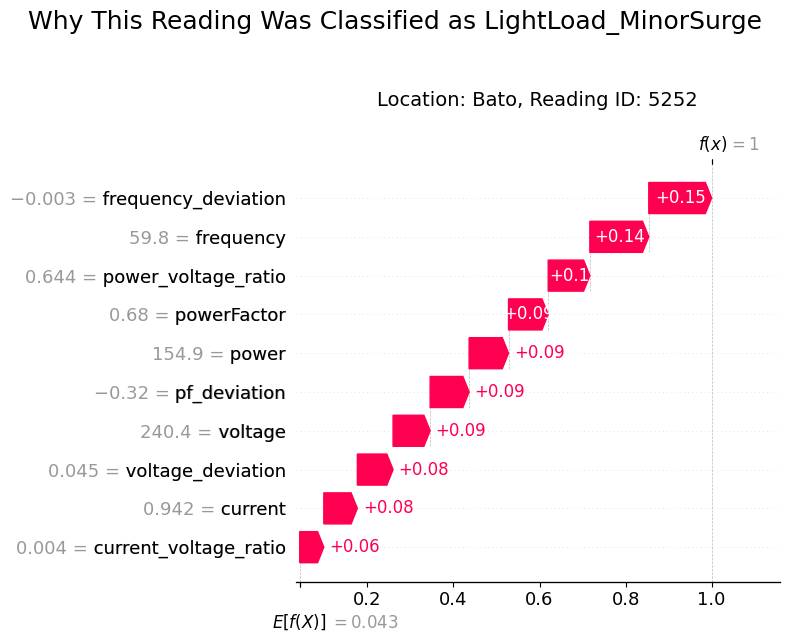


Top features contributing to this reading's classification:
  frequency_deviation: 0.1460 (increases probability)
  • Value: -0.0033
  frequency: 0.1370 (increases probability)
  • Value: 59.8000
  power_voltage_ratio: 0.0968 (increases probability)
  • Value: 0.6441
  powerFactor: 0.0922 (increases probability)
  • Value: 0.6800
  power: 0.0916 (increases probability)
  • Value: 154.9000


{'reading_idx': 5252,
 'class': 'LightLoad_MinorSurge',
 'location': 'Bato',
 'shap_values': array([0.08615594, 0.07795918, 0.13696246, 0.09159173, 0.092187  ,
        0.08299715, 0.14603732, 0.09057395, 0.09678979, 0.05599906]),
 'feature_importance': frequency_deviation      0.146037
 frequency                0.136962
 power_voltage_ratio      0.096790
 powerFactor              0.092187
 power                    0.091592
 pf_deviation             0.090574
 voltage                  0.086156
 voltage_deviation        0.082997
 current                  0.077959
 current_voltage_ratio    0.055999
 dtype: float64}

In [2]:
def explain_sensor_reading(reading_idx=None, search_criteria=None, model=model, X_test=X_test, y_test=y_test, 
                          feature_cols=feature_cols, explainer=best_explainer, output_dir="xai_plots"):
    """
    Generate a local explanation for a specific sensor reading.
    
    Parameters:
    -----------
    reading_idx : int or None
        Index of the specific reading to explain. If None, will use search_criteria.
    search_criteria : dict or None
        Dictionary with feature conditions to find a reading, e.g., {'voltage': ('>',240), 'current': ('>', 10)}
    model : trained classifier model
    X_test : DataFrame with test features
    y_test : Series with test labels
    feature_cols : list of feature column names
    explainer : trained SHAP explainer
    output_dir : directory to save plots
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Select a reading based on criteria or index
    if reading_idx is None and search_criteria is not None:
        # Build a query from search criteria
        query_conditions = []
        for feature, (op, value) in search_criteria.items():
            query_conditions.append(f"{feature} {op} {value}")
        
        query = " & ".join(query_conditions)
        matching_rows = X_test.query(query)
        
        if len(matching_rows) == 0:
            print(f"No readings match the criteria: {query}")
            return
        
        reading_idx = matching_rows.index[0]
        print(f"Found reading at index {reading_idx} matching criteria: {query}")
    
    elif reading_idx is None:
        # If no criteria or index, use a random reading
        reading_idx = X_test.index[np.random.randint(0, len(X_test))]
        print(f"Using random reading at index {reading_idx}")
    
    # Get the instance data and its actual class
    instance = X_test.loc[reading_idx].values.reshape(1, -1)
    actual_class = y_test.loc[reading_idx]
    location = df.loc[reading_idx, 'location'] if 'location' in df.columns else "Unknown"
    
    print(f"\nAnalyzing sensor reading from {location} with index: {reading_idx}")
    print(f"This reading was classified as: {actual_class}")
    print(f"\nReading features:")
    feature_values = pd.Series(instance[0], index=feature_cols)
    print(feature_values)
    
    # Calculate SHAP values for this specific instance
    instance_shap_values = explainer.shap_values(instance)
    
    # Get the class index for this specific anomaly type
    class_idx = np.where(model.classes_ == actual_class)[0][0]
    
    # Extract the SHAP values for the specific class we want to explain
    if isinstance(instance_shap_values, list):
        # For TreeExplainer with multi-class output
        shap_values_plot = instance_shap_values[class_idx][0]  # First sample, specific class
        base_value = explainer.expected_value[class_idx]
    elif len(instance_shap_values.shape) == 3:
        # For 3D array from other explainers (samples, features, classes)
        shap_values_plot = instance_shap_values[0, :, class_idx]
        if isinstance(explainer.expected_value, np.ndarray) or isinstance(explainer.expected_value, list):
            base_value = explainer.expected_value[class_idx]
        else:
            base_value = explainer.expected_value
    else:
        # For single output or other explainers
        shap_values_plot = instance_shap_values[0]  # Just take the first sample
        if hasattr(explainer, 'expected_value'):
            base_value = explainer.expected_value
        else:
            base_value = np.mean(y_train.map(lambda x: 1 if x == actual_class else 0))
    
    # Create a larger figure with better spacing
    plt.figure(figsize=(14, 10))
    
    # Create the waterfall plot
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values_plot,
            base_values=base_value,
            data=instance[0],
            feature_names=feature_cols
        ),
        max_display=10,
        show=False
    )
    
    # Add title with proper spacing and formatting
    plt.suptitle(f"Why This Reading Was Classified as {actual_class}", 
              fontsize=18, y=0.98)
    plt.title(f"Location: {location}, Reading ID: {reading_idx}", 
              fontsize=14, pad=20)
    
    # Improve layout
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space at top for the title
    
    # Save with higher resolution
    filename = f"{output_dir}/specific_reading_explanation_{reading_idx}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nSaved explanation plot to: {filename}")
    plt.show()
    
    # Print the top contributing features for this specific reading
    feature_importance = pd.Series(np.abs(shap_values_plot), index=feature_cols).sort_values(ascending=False)
    print("\nTop features contributing to this reading's classification:")
    for feat, imp in feature_importance.head(5).items():
        direction = "increases" if shap_values_plot[feature_cols.index(feat)] > 0 else "decreases"
        print(f"  {feat}: {imp:.4f} ({direction} probability)")
        print(f"  • Value: {instance[0][feature_cols.index(feat)]:.4f}")
    
    return {
        'reading_idx': reading_idx,
        'class': actual_class,
        'location': location,
        'shap_values': shap_values_plot,
        'feature_importance': feature_importance
    }

# Example usage:

# 1. Explain a specific reading by index
explain_sensor_reading(reading_idx=5252)

# 2. Find and explain a reading with specific characteristics
# explain_sensor_reading(search_criteria={'voltage': ('>', 240), 'current': ('>', 15)})

# 3. Find and explain readings for different anomaly types
# For example, to find a specific anomaly type:
# matching_index = y_test[y_test == "SevereVoltageDip"].index[0]
# explain_sensor_reading(reading_idx=matching_index)